In [2]:
import os
import numpy as np

In [6]:
def load_y_data(y_path):
    y = np.loadtxt(y_path, dtype=np.int32).reshape(-1,1)
    # change labels range from 1-6 t 0-5, this enables a sparse_categorical_crossentropy loss function
    return y - 1

def load_X_data(X_path):
    X_signal_paths = [X_path + file for file in os.listdir(X_path)]
    X_signals = [np.loadtxt(path, dtype=np.float32) for path in X_signal_paths]
    return np.transpose(np.array(X_signals), (1, 2, 0))

PATH = 'C:/Users/Achaya ShreeKrishna/Ipython_work/UCI HAR Dataset/'
LABEL_NAMES = ["Walking", "Walking upstairs", "Walking downstairs", "Sitting", "Standing", "Laying"]

# load X data
X_train = load_X_data(PATH + 'train/Inertial Signals/')
X_test = load_X_data(PATH + 'test/Inertial Signals/')
# load y label
y_train = load_y_data(PATH + 'train/y_train.txt')
y_test = load_y_data(PATH + 'test/y_test.txt')

print("useful information:")
print(f"shapes (n_samples, n_steps, n_signals) of X_train: {X_train.shape} and X_test: {X_test.shape}")
X_all = np.concatenate([X_train, X_test])
print(f"all X's have following mean: {format(X_all.mean(), '.2f')} and standard derivation: {format(X_all.std(), '.2f')} ")

useful information:
shapes (n_samples, n_steps, n_signals) of X_train: (7352, 128, 9) and X_test: (2947, 128, 9)
all X's have following mean: 0.10 and standard derivation: 0.40 


In [7]:
import pywt
import matplotlib.pyplot as plt

def split_indices_per_label(y):
    indicies_per_label = [[] for x in range(0,6)]
    # loop over the six labels
    for i in range(6): 
        indicies_per_label[i] = np.where(y == i)[0]
    return indicies_per_label

def plot_cwt_coeffs_per_label(X, label_indicies, label_names, signal, sample, scales, wavelet):
    
    fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12,5))
    
    for ax, indices, name in zip(axs.flat, label_indicies, label_names):
        # apply  PyWavelets continuous wavelet transfromation function
        coeffs, freqs = pywt.cwt(X[indices[sample],:, signal], scales, wavelet = wavelet)
        # create scalogram
        ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
        ax.set_title(name)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('Scale')
        ax.set_xlabel('Time')
    plt.tight_layout()

# list of list of sample indicies per activity
train_labels_indicies = split_indices_per_label(y_train)

#signal indicies: 0 = body acc x, 1 = body acc y, 2 = body acc z, 3 = body gyro x, 4 = body gyro y, 5 = body gyro z, 6 = total acc x, 7 = total acc y, 8 = total acc z
signal = 3 # signal index
sample = 1 # sample index of each label indicies list
scales = np.arange(1, 65) # range of scales
wavelet = 'morl' # mother wavelet


In [8]:
from skimage.transform import resize

def create_cwt_images(X, n_scales, rescale_size, wavelet_name = "morl"):
    n_samples = X.shape[0] 
    n_signals = X.shape[2] 
    
    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1) 
    
    # pre allocate array
    X_cwt = np.ndarray(shape=(n_samples, rescale_size, rescale_size, n_signals), dtype = 'float32')
    
    for sample in range(n_samples):
        if sample % 1000 == 0:
            print(sample)
        for signal in range(n_signals):
            serie = X[sample, :, signal]
            # continuous wavelet transform 
            coeffs, freqs = pywt.cwt(serie, scales, wavelet_name)
            # resize the 2D cwt coeffs
            rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode = 'constant')
            X_cwt[sample,:,:,signal] = rescale_coeffs
            
    return X_cwt
  
# amount of pixels in X and Y 
rescale_size = 64
# determine the max scale size
n_scales = 64

X_train_cwt = create_cwt_images(X_train, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {X_train_cwt.shape}")
X_test_cwt = create_cwt_images(X_test, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {X_test_cwt.shape}")


0
1000
2000
3000
4000
5000
6000
7000
shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: (7352, 64, 64, 9)
0
1000
2000
shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: (2947, 64, 64, 9)


In [10]:
#import keras (high level API) wiht tensorflow as backend
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

def build_cnn_model(activation, input_shape):
    model = Sequential()
    
    # 2 Convolution layer with Max polling
    model.add(Conv2D(32, 5, activation = activation, padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D())  
    model.add(Flatten())
    
    # 3 Full connected layer
    model.add(Dense(128, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(54, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(6, activation = 'softmax')) # 6 classes
    
    # summarize the model
    print(model.summary())
    return model

def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs):

    # compile the model
      # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])
    
    # define callbacks
    callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)]
    
    # fit the model
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))
    
    return model, history

# shape of the input images
input_shape = (X_train_cwt.shape[1], X_train_cwt.shape[2], X_train_cwt.shape[3])

# create cnn model
cnn_model = build_cnn_model("relu", input_shape)
# train cnn model
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train_cwt, y_train, X_test_cwt, y_test, 368, 10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        7232      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dense_4 (Dense)              (None, 54)               

Accuracy: 91.45%


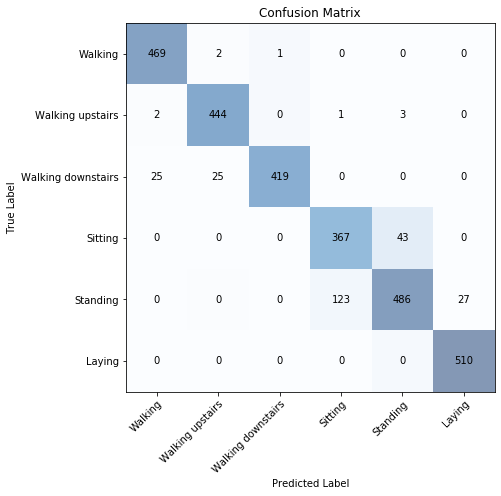

In [11]:
import seaborn as sns
from sklearn import metrics

def create_confusion_matrix(y_pred, y_test):    
    #calculate the confusion matrix
    confmat = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(confmat, cmap=plt.cm.Blues, alpha=0.5)

    n_labels = len(LABEL_NAMES)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(LABEL_NAMES)
    ax.set_yticklabels(LABEL_NAMES)

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # loop over data dimensions and create text annotations.
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')
    
    # avoid that the first and last row cut in half
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

# make predictions for test data
y_pred = trained_cnn_model.predict_classes(X_test_cwt)
# determine the total accuracy 
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

create_confusion_matrix(y_pred, y_test)